# Travel Booking Agent 

In [14]:
import openai
import uuid
import os
import json
from typing import Annotated, Optional, Dict, List, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from dotenv import load_dotenv
load_dotenv()

True

In [15]:
# setup model and enviroment variable
api_key = os.getenv("OPENAI_API_KEY")
if not os.getenv("OPENAI_API_KEY"):
    print("OPENAI API KEY NOT FOUND")

openai.api_key = api_key

In [16]:
def get_llm(system_prompt:str, user_input: str, response_format=None, tools=None) -> str:
    response = openai.chat.completions.create(
        model=os.getenv('MODEL_NAME'),
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_input}
        ],
        response_format=response_format,
        tools=tools
    )
    return response.choices[0].message.content

In [17]:
# Prompt Definations

# system_prompt_decider_agent = """

# You are the decider agent in a travel assistance system. Your role is to analyze the user's query and decide how to handle it. There are three specialized agents:

# - flight_booking: for queries about booking flights
# - hotel_booking: for queries about booking hotels
# - destination_finder: for queries about finding travel destinations

# If the user's query is about one of these topics, route it to the corresponding agent. If the query is general or doesn't fit into these categories, provide a response directly.

# Respond in JSON format with one of the following structures:
# 1. {"action": "route", "agent": "flight_booking"}
# 2. {"action": "route", "agent": "hotel_booking"}
# 3. {"action": "route", "agent": "destination_finder"}
# 4. {"action": "respond", "response": "your response here"}

# Use the "route" action with the appropriate agent name if the query is specifically about that topic. Use the "respond" action for all other queries, providing an appropriate response.

# Examples:
# - User: "I want to book a flight to London."
#   Response: {"action": "route", "agent": "flight_booking"}
# - User: "Can you help me find a hotel in Paris?"
#   Response: {"action": "route", "agent": "hotel_booking"}
# - User: "What are some good places to visit in Italy?"
#   Response: {"action": "route", "agent": "destination_finder"}
# - User: "How are you today?"
#   Response: {"action": "respond", "response": "I'm doing well, thank you for asking! How can I assist you today?"}
# - User: "I need help with my trip."
#   Response: {"action": "respond", "response": "Sure, I can help with your trip. What specifically do you need assistance with? Booking a flight, finding a hotel, or getting destination suggestions?"}

# Analyze the user's query and respond accordingly.


# """


system_prompt_decider_agent = """

You are the decider agent in a travel assistance system. Your role is to analyze the user's query and decide how to handle it. There are three specialized agents:

- flight_booking: for queries about booking flights
- hotel_booking: for queries about booking hotels
- destination_finder: for queries about finding travel destinations

If the user's query mentions one or more specific tasks related to these agents, route it to the corresponding agent(s). If the query is general, doesn’t specify any particular task, or mentions tasks not covered by the specialized agents, provide a response directly.

Respond in JSON format with one of the following structures:
1. {"action": "route", "agents": ["flight_booking"]}
2. {"action": "route", "agents": ["hotel_booking", "destination_finder"]}
3. {"action": "respond", "response": "your response here"}

Use the "route" action with the appropriate agent names in the "agents" list if the query specifies tasks related to those agents. Use the "respond" action for all other queries, providing an appropriate response.

Examples:
- User: "I want to book a flight to London."
  Response: {"action": "route", "agents": ["flight_booking"]}
- User: "Can you help me find a hotel in Paris?"
  Response: {"action": "route", "agents": ["hotel_booking"]}
- User: "What are some good places to visit in Italy?"
  Response: {"action": "route", "agents": ["destination_finder"]}
- User: "I want to book a flight and a hotel in Paris."
  Response: {"action": "route", "agents": ["flight_booking", "hotel_booking"]}
- User: "Can you find me a destination and book a hotel there?"
  Response: {"action": "route", "agents": ["destination_finder", "hotel_booking"]}
- User: "How are you today?"
  Response: {"action": "respond", "response": "I'm doing well, thank you for asking! How can I assist you today?"}
- User: "I need help with my trip."
  Response: {"action": "respond", "response": "Sure, I can help with your trip. What specifically do you need assistance with? Booking a flight, finding a hotel, or getting destination suggestions?"}
- User: "I need to rent a car."
  Response: {"action": "respond", "response": "I apologize, but I can only assist with booking flights, finding hotels, and suggesting destinations. Is there anything else I can help you with?"}

Analyze the user's query, identify any specific tasks related to the specialized agents, and respond accordingly. If multiple tasks are mentioned, include all relevant agents in the "agents" list. If no specific tasks are identified or the query is unrelated, use the "respond" action with an appropriate message.

"""

### Defining the Graph

In [19]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    user_query: str
    assistant_response: str
    next_node: dict      #set by the decider node
    next_node_name: str
    agent_queue: List[str]
    agent_outputs: List[str]  

In [20]:
def main_decider_node(state: State):
    """ This Node will decide which agent we have to call based on the user query """
    user_query = state['user_query']
    res = get_llm(
        system_prompt=system_prompt_decider_agent,
        user_input=user_query,
    )

    response = json.loads(res)

    # not state initial message
    if not state.get('messages'):
        state['messages'] = []
        state['messages'].append(HumanMessage(content=user_query))
        state['messages'].append(AIMessage(content=str(response)))

    state['next_node'] = response

    if response.get("action") == "route":
        state["agent_queue"] = response["agents"]
        state["next_node_name"] = "decide_route_agent"
    else:
        state["assistant_response"] = response.get("response", "")
        state["next_node_name"] = END
    return state


In [21]:

def decide_route_agent(state: State):
    """Determines the next agent to process or ends the flow if no agents remain."""
    if state["agent_queue"]:
        next_agent = state["agent_queue"].pop(0)  # Process the first agent in the list
        state["next_node_name"] = next_agent
    else:
        state["assistant_response"] = "\n".join(state["agent_outputs"])
        state["next_node_name"] = END
    return state


In [22]:
#define tools

def book_flight(**args):
    """ Book a flight ticket"""
    
    name = args.get('name')
    departure = args.get('departure')
    arrival = args.get('arrival')
    billing_address = args.get('billing_address')
    
    if not all([name, departure, arrival, billing_address]):
        return "Please provide all the required information for flight booking"
    
    ticket_no = uuid.uuid4()
    return f"Flight book with ticket no : {ticket_no} for {name} from {departure} to {arrival} at {billing_address}"


def book_hotel(**args):
    """Book a hotel room"""
    name = args.get("name")
    no_days_stay = args.get("no_days_stay")
    identity_type = args.get("identity_type")
    identity_number = args.get("identity_number")
    
    if not all([name, no_days_stay, identity_type, identity_number]):
        return "Please provide all the required details for hotel booking"   
    
    booking_no = uuid.uuid4()
    return f"Hotel booked with booking no: {booking_no} for {name} for {no_days_stay} days using {identity_type} with id {identity_number}"

    

In [ ]:
# def hotel_booking_agent(state: State) -> State:
#     response = f"Hotel booked for query: {state['user_query']}  booking id of hotel is 3243"
#     state["agent_outputs"].append(response)
#     return state

# def flight_booking_agent(state: State) -> State:
#     response = f"Flight booked for query: {state['user_query']}  id of 4234248 "
#     state["agent_outputs"].append(response)
#     return state

# def destination_finder_agent(state: State) -> State:
#     # response = f"Destination suggestions for query: {state['user_query']}"
#     response = "mathura is good place to visit"
#     state["agent_outputs"].append(response)
#     return state


flight_tool = {
    "type": "function",
    "function": {
        "name": "book_flight",
        "description": "book a flight ticket ",
        "parameters": {
            "type": "object",
            "properties": {
                "name": {
                    "type": "string",
                    "description": "name of the person"
                },
                "departure": {
                    "type": "string",
                    "description": "departure city name"
                },
                "arrival": {
                    "type": "string",
                    "description": "arrival city name"
                },
                "billing_address": {
                    "type": "string",
                    "description": "billing address of the person"
                }
                
            },
            "required": [
                "name",
                "departure",
                "arrival",
                "billing_address"
                
            ],
            "additionalProperties": False
        },
        "strict": True
    }
}


hotel_tool = {
    "type": "function",
    "function": {
        "name": "book_hotel",
        "description": "book a hotel ticket ",
        "parameters": {
            "type": "object",
            "properties": {
                "name": {
                    "type": "string",
                    "description": "name of the person"
                },
                "no_days_stay": {
                    "type": "integer",
                    "description": "No of days to stay"
                },
                "identity_type": {
                    "type": "string",
                    "description": "type of identity used during verification"
                },
                "identity_number": {
                    "type": "integer",
                    "description": "identity number"
                }
                
            },
            "required": [
                "name",
                "no_days_stay",
                "identity_type",
                "identity_number"
                
            ],
            "additionalProperties": False
        },
        "strict": True
    }
}


def hotel_booking_agent(state: State) -> State:
    user_query = state['user_query']
    
    system_prompt_hotel = """
    You are a hotel booking assistant. From the user's query, extract the guest's name, number of days to stay, identity type, and identity number. 
    If all four are present, output a JSON object with the tool call as follows:
    {"tool": "book_hotel", "args": {"name": "John Doe", "no_days_stay": 3, "identity_type": "passport", "identity_number": 1234567}}
    Ensure that 'no_days_stay' and 'identity_number' are integers. 
    If any information is missing, output a message indicating what's missing, e.g., 
    {"response": "Please provide the number of days to stay and identity number."}
    """
    
    # Call the LLM with hotel_tool (make sure to pass it as a list)
    response_str = get_llm(system_prompt=system_prompt_hotel, user_input=user_query, tools=[hotel_tool])
    print("Raw LLM response:", response_str)
    
    # Attempt to parse the response as JSON
    try:
        parsed_response = json.loads(response_str)
        # Ensure the parsed response is a dict
        if not isinstance(parsed_response, dict):
            raise ValueError("Parsed response is not an object")
        response = parsed_response
    except Exception as e:
        error_msg = f"Error parsing response: {response_str}"
        state['assistant_response'] = error_msg
        state['messages'].append(AIMessage(content=error_msg))
        return state

    # Process the parsed response
    if 'response' in response:
        # The assistant provided a direct response message indicating missing info
        # state['assistant_response'] = response['response']
        state["agent_outputs"].append(response['response'])
        state['messages'].append(AIMessage(content=response['response']))
        
    elif 'tool' in response and response.get('tool') == 'book_hotel':
        # Expecting tool arguments in the response
        tool_args = response.get('args')
        if not isinstance(tool_args, dict):
            error_msg = "Tool arguments missing or not in expected format."
            # state['assistant_response'] = error_msg
            
            state["agent_outputs"].append(error_msg)
            state['messages'].append(AIMessage(content=error_msg))
        else:
            result = book_hotel(**tool_args)
            # state['assistant_response'] = result
            state["agent_outputs"].append(result)
            state['messages'].append(AIMessage(content=result))
    else:
        unknown_msg = "Unknown response structure."
        # state['assistant_response'] = unknown_msg
        state["agent_outputs"].append(unknown_msg)
        state['messages'].append(AIMessage(content=unknown_msg))
            
    return state
    

def flight_booking_agent(state: State) -> State:
    
    user_query = state['user_query']
    system_prompt_flight = """
        You are a flight booking assistant. From the user's query, extract the passenger's name, departure city, arrival city, and billing address. If all four are present, output a JSON object with the tool call, like:
        {"tool": "book_flight", "args": {"name": "John Doe", "departure": "CityA", "arrival": "CityB", "billing_address": "123 Main St"}}
        If any are missing, output a message indicating what's missing, like:
        {"response": "Please provide [list of missing items]."}
        where [list of missing items] specifies what is needed, e.g., 'the passenger's name and billing address' or 'the arrival city'.
    """
    
        # Call the LLM with hotel_tool (make sure to pass it as a list)
    response_str = get_llm(system_prompt=system_prompt_flight, user_input=user_query, tools=[flight_tool])
    print("Raw LLM flight response:", response_str)
    
    # Attempt to parse the response as JSON
    try:
        parsed_response = json.loads(response_str)
        # Ensure the parsed response is a dict
        if not isinstance(parsed_response, dict):
            raise ValueError("Parsed response is not an object")
        response = parsed_response
    except Exception as e:
        error_msg = f"Error parsing response: {response_str}"
        state['assistant_response'] = error_msg
        state['messages'].append(AIMessage(content=error_msg))
        return state

    # Process the parsed response
    if 'response' in response:
        # The assistant provided a direct response message indicating missing info
        # state['assistant_response'] = response['response']
        state["agent_outputs"].append(response['response'])
        state['messages'].append(AIMessage(content=response['response']))
        
    elif 'tool' in response and response.get('tool') == 'book_flight':
        # Expecting tool arguments in the response
        tool_args = response.get('args')
        if not isinstance(tool_args, dict):
            error_msg = "Tool arguments missing or not in expected format."
            # state['assistant_response'] = error_msg
            state["agent_outputs"].append(error_msg)
            state['messages'].append(AIMessage(content=error_msg))
        else:
            result = book_flight(**tool_args)
            # state['assistant_response'] = result
            state["agent_outputs"].append(result)
            state['messages'].append(AIMessage(content=result))
    else:
        unknown_msg = "Unknown response structure."
        # state['assistant_response'] = unknown_msg
        state["agent_outputs"].append(unknown_msg)
        state['messages'].append(AIMessage(content=unknown_msg))
    
    return state
    

def destination_finder_agent(state: State) -> State:
    # response = f"Destination suggestions for query: {state['user_query']}"
    response = "mathura is good place to visit"
    state["agent_outputs"].append(response)
    return state


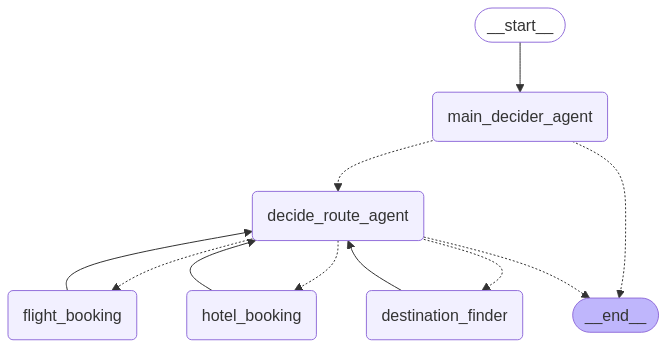

In [24]:
# Define the Graph

travel_graph = StateGraph(State)

travel_graph.add_node("main_decider_agent", main_decider_node)
travel_graph.add_node('decide_route_agent', decide_route_agent)
travel_graph.add_node('flight_booking', flight_booking_agent)
travel_graph.add_node('hotel_booking', hotel_booking_agent)
travel_graph.add_node('destination_finder', destination_finder_agent)


# set the entry point
travel_graph.add_edge(START, 'main_decider_agent')
# travel_graph.add_edge('main_decider_agent', 'decide_route_agent')
travel_graph.add_conditional_edges(
    'main_decider_agent',
    lambda state: state['next_node_name'],
    {
        "decide_route_agent": "decide_route_agent",
        END: END
    }

)
# travel_graph.set_entry_point('main_decider_agent')
travel_graph.add_conditional_edges(
    'decide_route_agent',
    lambda state: state["next_node_name"],
    {
        "flight_booking": "flight_booking",
        "hotel_booking": "hotel_booking",
        "destination_finder": "destination_finder",
        END: END
    }
)

# travel_graph.add_edge('flight_booking', END)
# travel_graph.add_edge('hotel_booking', END)
# travel_graph.add_edge('destination_finder', END)

for agent in ["flight_booking", "hotel_booking", "destination_finder"]:
    travel_graph.add_edge(agent, "decide_route_agent")

compiled_graph = travel_graph.compile()


from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
        Image(
            compiled_graph.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )

In [25]:
while True:
    user_query = input("Enter your query: ")

    if user_query=='exit':
        break


    initial_state = {
        "messages": [],
        "user_query": user_query,
        "assistant_response": "",
        "next_node": {},
        "next_node_name": "",
        "agent_queue": [],
        "agent_outputs": []
    }
    final_state = compiled_graph.invoke(initial_state)
    print("Final state:", final_state)
    print("Assistant response:", final_state["assistant_response"])

Raw LLM flight response: {"tool": "book_flight", "args": {"name": "anshu", "departure": "New York", "arrival": "Mathura", "billing_address": "New York"}}
Raw LLM response: {"tool": "book_hotel", "args": {"name": "anshu", "no_days_stay": 5, "identity_type": "passport", "identity_number": 939494}}
Final state: {'messages': [HumanMessage(content='can you find a best place for visit and also book a flight and hotel ticket name is anshu living at new york i want to stay 5 days and also for my identity passport no is 939494 for arrival city is mathura and  bill details send to newyork', additional_kwargs={}, response_metadata={}, id='05392d57-6c35-48fc-a8ec-2f63543c1211'), AIMessage(content="{'action': 'route', 'agents': ['destination_finder', 'flight_booking', 'hotel_booking']}", additional_kwargs={}, response_metadata={}, id='c28be4b7-d106-4f5f-b272-5def264a1dbf'), AIMessage(content='Flight book with ticket no : 60918d16-ee83-452e-ace6-30423b501b3d for anshu from New York to Mathura at New

In [26]:
initial_state = {
    "messages": [],
    "user_query": "'can you find a best place for visit and also book a flight and hotel ticket name is anshu living at new york i want to stay 5 days and also for my identity passport no is 939494 for arrival city is mathura and  bill details send to newyork",
    "assistant_response": "",
    "next_node": {},
    "next_node_name": "",
    "agent_queue": [],
    "agent_outputs": []
}
final_state = compiled_graph.invoke(initial_state)
print("Final state:", final_state)
print("Assistant response:", final_state["assistant_response"])


Raw LLM flight response: {"tool": "book_flight", "args": {"name": "anshu", "departure": "New York", "arrival": "Mathura", "billing_address": "New York"}}
Raw LLM response: {"tool": "book_hotel", "args": {"name": "anshu", "no_days_stay": 5, "identity_type": "passport", "identity_number": 939494}}
Final state: {'messages': [HumanMessage(content="'can you find a best place for visit and also book a flight and hotel ticket name is anshu living at new york i want to stay 5 days and also for my identity passport no is 939494 for arrival city is mathura and  bill details send to newyork", additional_kwargs={}, response_metadata={}, id='c994ecc8-6b16-4b44-b37c-4785af926479'), AIMessage(content="{'action': 'route', 'agents': ['destination_finder', 'flight_booking', 'hotel_booking']}", additional_kwargs={}, response_metadata={}, id='3803bccc-e512-4e15-9ba5-5646434a9ef0'), AIMessage(content='Flight book with ticket no : 6ce7b435-3246-4c82-8ba6-9341017cf9fb for anshu from New York to Mathura at Ne